<a href="https://colab.research.google.com/github/psagar2/recipes/blob/main/terapixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=c1217c809a3d7ab20919dc5e263458835e5fe13e9dfc04076288840ea824bc44
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [2]:
import pandas as pd
import pandasql as ps 
import matplotlib.pyplot as plt


In [6]:
df  = pd.read_csv('gpu.csv')
df1 = pd.read_csv('task-x-y.csv')
df2 = pd.read_csv('application-checkpoints.csv')
# df3=pd.read_csv('mergetaskapplication.csv')
# df4=pd.read_csv('mergegpuapplication.csv')
# df5=pd.read_csv('mergeall.csv')

In [3]:
# df=ps.sqldf('select avg(powerDrawWatt), avg(gpuTempC), avg(gpuUtilPerc), avg(gpuMemUtilPerc), hostname from df group by hostname ')

In [9]:
dfsavingconfig=ps.sqldf('select * from df2 where eventName="Saving Config" ')
dftotalrender=ps.sqldf('select * from df2 where eventName="TotalRender" ')
dfrender=ps.sqldf('select * from df2 where eventName="Render" ')
dftiling=ps.sqldf('select * from df2 where eventName="Tiling" ')
dfuploading=ps.sqldf('select * from df2 where eventName="Uploading" ')

In [ ]:
# dfsavingconfigmerge=pd.read_csv('dfsavingconfigmerge.csv')

In [10]:
# dfsavingconfigmerge = pd.merge(df, dfsavingconfig, on = ["hostname"])

In [11]:
# dfsavingconfigmerge.to_csv('dfsavingconfigmerge.csv')

In [5]:
# dftotalrendermerge = pd.merge(df, dftotalrender, on = ["hostname"])

In [6]:
# dftotalrendermerge.to_csv('dftotalrendermerge.csv')

In [4]:
# dfrendermerge = pd.merge(df, dfrender, on = ["hostname"])

In [5]:
# dfrendermerge.to_csv('dfrendermerge.csv')

In [ ]:
# dfrendermerge=pd.read_csv('dfrendermerge.csv')

In [10]:
df.hostname.nunique()

1024

In [11]:
df2.hostname.nunique()

1024

In [7]:
df.gpuSerial.nunique()

1024

In [5]:
df.head()

,timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,2018-11-08T08:27:10.314Z,8b6a0eebc87b4cb2b0539e81075191b900001C,3.230000e+11,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,131.55,48,92,53
1,2018-11-08T08:27:10.192Z,d8241877cd994572b46c861e5d144c85000000,3.240000e+11,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,117.03,40,92,48
2,2018-11-08T08:27:10.842Z,db871cd77a544e13bc791a64a0c8ed50000006,3.230000e+11,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,121.64,45,91,44
3,2018-11-08T08:27:10.424Z,b9a1fa7ae2f74eb68f25f607980f97d7000010,3.250000e+11,GPU-ad773c69-c386-a4be-b214-1ea4fc6045df,50.23,38,90,43
4,2018-11-08T08:27:10.937Z,db871cd77a544e13bc791a64a0c8ed50000003,3.230000e+11,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,141.82,41,90,47


In [8]:
df

,timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,2018-11-08T08:27:10.314Z,8b6a0eebc87b4cb2b0539e81075191b900001C,323217055910,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,131.55,48,92,53
1,2018-11-08T08:27:10.192Z,d8241877cd994572b46c861e5d144c85000000,323617020295,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,117.03,40,92,48
2,2018-11-08T08:27:10.842Z,db871cd77a544e13bc791a64a0c8ed50000006,323217056562,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,121.64,45,91,44
3,2018-11-08T08:27:10.424Z,b9a1fa7ae2f74eb68f25f607980f97d7000010,325217085931,GPU-ad773c69-c386-a4be-b214-1ea4fc6045df,50.23,38,90,43
4,2018-11-08T08:27:10.937Z,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,141.82,41,90,47
...,...,...,...,...,...,...,...,...
1543676,2018-11-08T08:31:18.873Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,26.99,30,0,0
1543677,2018-11-08T08:31:24.933Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,26.90,29,0,0
1543678,2018-11-08T08:31:32.998Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,26.88,29,0,0
1543679,2018-11-08T08:31:39.057Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,26.89,29,0,0


In [9]:
df3 = pd.merge(df, df2, on = ["timestamp"])

In [10]:
df3

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.875Z,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af
1,2018-11-08T08:27:10.875Z,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af
2,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
3,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
4,2018-11-08T08:27:10.359Z,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337685,2018-11-08T08:24:23.967Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,124.28,39,89,45,6139a35676de44d6b61ec247f0ed8657000017,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8784602b-8752-46c9-8be3-dce695cad495
337686,2018-11-08T08:27:49.025Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,43.15,38,0,0,5903af3699134795af7eafc605ae5fc700000X,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,83940c2d-f3e3-45c3-a58c-9e8d5277bc1c
337687,2018-11-08T08:27:49.025Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,43.15,38,0,0,5903af3699134795af7eafc605ae5fc700000X,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,83940c2d-f3e3-45c3-a58c-9e8d5277bc1c
337688,2018-11-08T08:29:58.159Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,27.27,32,0,0,4a79b6d2616049edbf06c6aa58ab426a00000X,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2c429cac-7be1-4c04-be01-50bd48bedcfe


In [11]:
df3start=df3[(df3['eventType']=='START')]
df3stop=df3[(df3['eventType']=='STOP')]

In [12]:
df3merge=pd.merge(df3start,df3stop,on=['taskId','eventName'])

In [13]:
df3merge['timestamp_x']=pd.to_datetime(df3merge['timestamp_x'])
df3merge['timestamp_y']=pd.to_datetime(df3merge['timestamp_y'])

In [14]:
df3merge['timestamp_x'].dtype
df3merge['timestamp_y'].dtype

datetime64[ns, UTC]

In [15]:
df3merge['timediff']=df3merge['timestamp_y']-df3merge['timestamp_x']

In [16]:
df3merge['timediff']=(df3merge['timediff'].dt.total_seconds())

In [17]:
df3merge['timediff']

0         1.121
1        46.741
2         1.032
3         1.032
4        47.483
          ...  
86628    48.771
86629    23.929
86630     0.972
86631     0.002
86632     0.002
Name: timediff, Length: 86633, dtype: float64

In [18]:
df3merge

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.875000+00:00,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000+00:00,95b4ae6d890e4c46986d91d7ac4bf08200000T,324917052614,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121
1,2018-11-08 08:27:10.624000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741
2,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,04dc4e9647154250beeee51b866b071500001C,323617020155,GPU-51b7ec74-a5ac-06b7-1fd0-9c11ce579ffc,28.05,39,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
3,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,b9a1fa7ae2f74eb68f25f607980f97d7000012,325117172395,GPU-50f23433-71f3-6f16-3c86-0de884dc7493,44.21,37,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
4,2018-11-08 08:27:10.678000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000H,323617043161,GPU-82ba6a59-510a-9995-4167-0945785066b3,27.05,35,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86628,2018-11-08 08:05:49.714000+00:00,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,97.68,41,91,57,04dc4e9647154250beeee51b866b0715000014,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8b8faa57-c9ec-4eb0-99b9-9bd6ef77e074,2018-11-08 08:06:38.485000+00:00,a77ef58b13ad4c01b769dac8409af3f800000L,323617020277,GPU-636b97cd-9ff5-cbf0-9b18-e462e3b8a6fb,88.59,39,94,47,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,48.771
86629,2018-11-08 08:05:49.714000+00:00,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,97.68,41,91,57,6139a35676de44d6b61ec247f0ed865700001A,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fa0834da-3d07-417a-b5ce-a84345f84f91,2018-11-08 08:06:13.643000+00:00,0d56a730076643d585f77e00d2d8521a00001D,324917053014,GPU-fd95a940-581a-15ac-2e82-96c00f9e1a9a,122.93,47,92,45,6139a35676de44d6b61ec247f0ed865700001A,S

In [ ]:
# df3merge.drop(columns=['gpuSerial_y','gpuUUID_y', 'powerDrawWatt_y', 'gpuTempC_y', 'hostname_y_y', 'hostname_x_y','jobId_y','timestammp_x'])

In [ ]:
# df3merge.drop(columns=[''])

In [19]:
eventtime=ps.sqldf('select eventName, sum(timediff) as total_time  from df3merge  where NOT eventName="TotalRender" group by eventName')

In [20]:
eventtime

,eventName,total_time
0,Render,703087.665
1,Saving Config,43.142
2,Tiling,16727.443
3,Uploading,23927.232


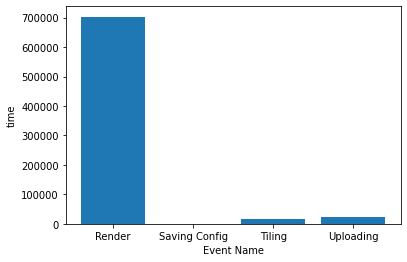

In [21]:
plt.bar(eventtime.eventName,eventtime.total_time )
plt.ylabel('time')
plt.xlabel('Event Name')
plt.rcParams['figure.figsize']=[15,8]

Gpu execution time is majorly dominated by Render as compared to tiling and uploading. therefore utilization of gpu should be in a way that most heavy task should be alloted the most powerfull GPU. so that the running cost can be kept low. so the task runtimes are majorly dominated by render.

In [22]:
print(df.describe())


          gpuSerial  powerDrawWatt      gpuTempC   gpuUtilPerc  gpuMemUtilPerc
count  1.543681e+06   1.543681e+06  1.543681e+06  1.543681e+06    1.543681e+06
mean   3.239836e+11   8.919838e+01  4.007560e+01  6.305820e+01    3.341359e+01
std    1.228841e+09   3.975742e+01  3.800243e+00  4.144816e+01    2.300107e+01
min    3.201181e+11   2.255000e+01  2.600000e+01  0.000000e+00    0.000000e+00
25%    3.236170e+11   4.499000e+01  3.800000e+01  0.000000e+00    0.000000e+00
50%    3.236170e+11   9.659000e+01  4.000000e+01  8.900000e+01    4.300000e+01
75%    3.250170e+11   1.213400e+02  4.200000e+01  9.200000e+01    5.100000e+01
max    3.252171e+11   1.970100e+02  5.500000e+01  1.000000e+02    8.300000e+01


0.5059063290736544


Text(0, 0.5, 'Temperature in celsius')

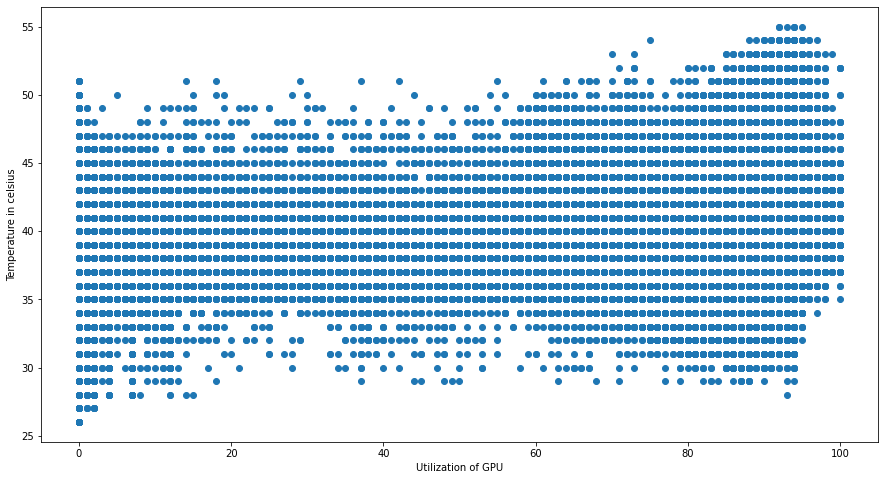

In [23]:
x=df.gpuUtilPerc
y=df.gpuTempC
print(x.corr(y))
plt.scatter(df.gpuUtilPerc,df.gpuTempC)
plt.xlabel("Utilization of GPU")
plt.ylabel("Temperature in celsius")

As it can be observed that correlation between temperature and utilization is about 0.5 and the graph depicts that high temperatures are achieved even when the gpu performence is low. hence there is no direct relation between these.
Moreover the cooling system is suggested to be used at all times and there running cost should be considered as an important cost compounding factor.

0.49278284152600066


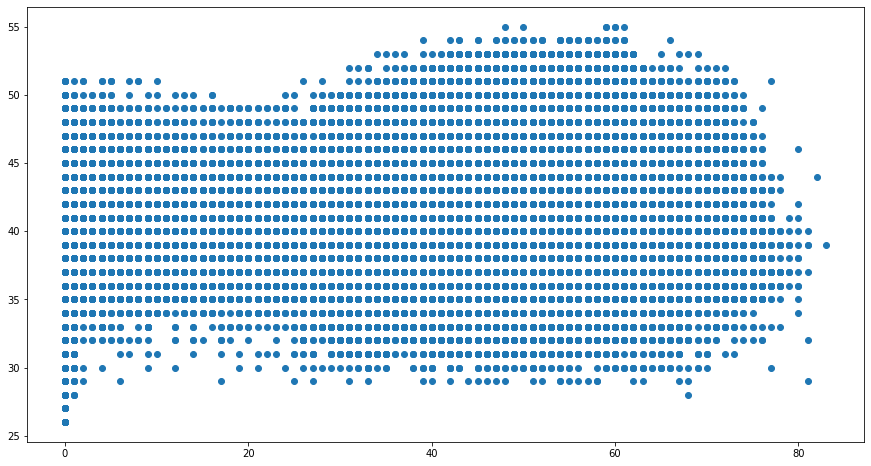

In [24]:
x=df.gpuMemUtilPerc
y=df.gpuTempC
print(x.corr(y))
plt.scatter(x,y)

0.5371909890230221


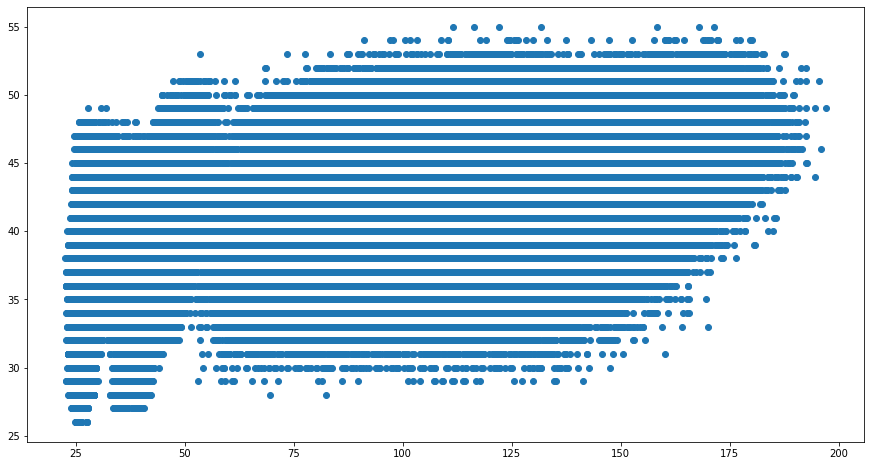

In [25]:
x=df.powerDrawWatt
y=df.gpuTempC
print(x.corr(y))
plt.scatter(x,y)

0.8707451224651878


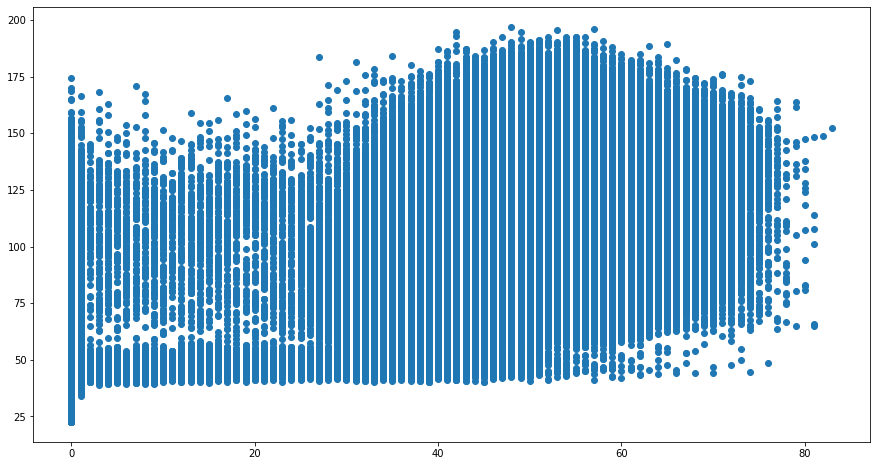

In [26]:
x=df.gpuMemUtilPerc
y=df.powerDrawWatt
print(x.corr(y))
plt.scatter(x,y)

0.8626730321864096


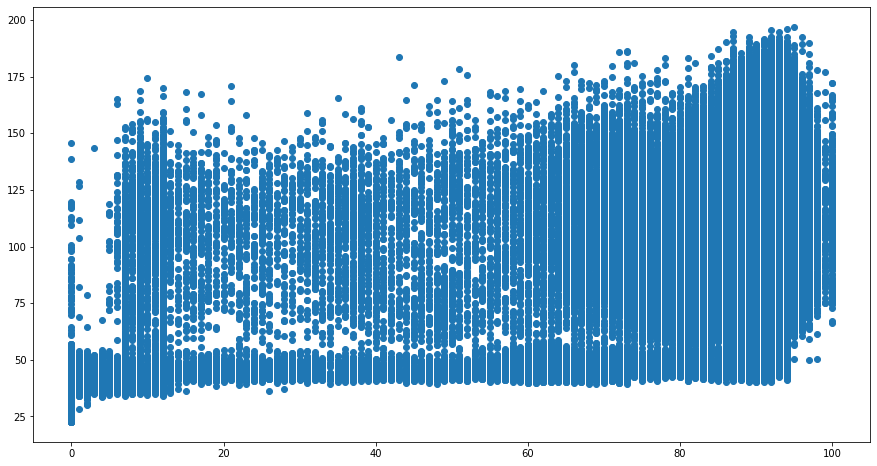

In [27]:
x=df.gpuUtilPerc
y=df.powerDrawWatt
print(x.corr(y))
plt.scatter(x,y)

0.9665710683356831


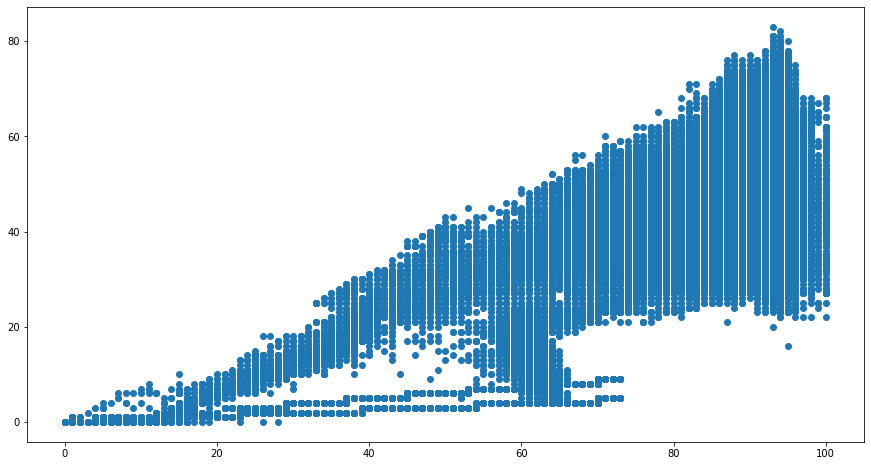

In [28]:
x=df.gpuUtilPerc
y=df.gpuMemUtilPerc
print(x.corr(y))
plt.scatter(x,y)

In [29]:
dftotalrender=ps.sqldf('select * from df3 where eventName="TotalRender" ')
dftotalrender

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,83ea61ac1ef54f27a3bf7bd0f41ecaa700000C,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c2e827e9-de83-452f-abf2-cc50d4293a3b
1,2018-11-08T08:27:10.574Z,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,db871cd77a544e13bc791a64a0c8ed50000010,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8a8e3266-68dd-4ef1-b99a-b3e88ec9a970
2,2018-11-08T08:27:07.808Z,265232c5f6814768aeefa66a7bec6ff600000A,323617042839,GPU-0a470a0d-0f60-58d8-7e32-be9c1b4f828c,47.64,37,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,76fe1add-66f8-4d52-aba3-750d07d9ff85
3,2018-11-08T08:27:07.808Z,cd44f5819eba427a816e7ce648adceb200000Z,323617042746,GPU-dbbe4b2d-299a-0324-b56a-3a1cef0df006,134.50,41,93,53,b9a1fa7ae2f74eb68f25f607980f97d700000H,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,76fe1add-66f8-4d52-aba3-750d07d9ff85
4,2018-11-08T08:27:13.475Z,265232c5f6814768aeefa66a7bec6ff600000K,323617020110,GPU-5f50560e-c1d9-4cdc-8076-02a03a4c8832,124.88,43,93,52,e7adc42d28814e518e9601ac2329c513000002,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,59f756d6-2e27-4c33-b44e-28aac785da46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67751,2018-11-08T08:04:32.992Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,28.22,36,0,0,0d56a730076643d585f77e00d2d8521a00000T,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b86620b9-93aa-4ae2-8d97-d68b1bac8d16
67752,2018-11-08T08:05:49.714Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,97.68,41,91,57,b9a1fa7ae2f74eb68f25f607980f97d7000011,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,d6474694-3e5f-4767-971e-c4e9d9c69d56
67753,2018-11-08T08:05:49.714Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,97.68,41,91,57,04dc4e9647154250beeee51b866b0715000014,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8b8faa57-c9ec-4eb0-99b9-9bd6ef77e074
67754,2018-11-08T08:05:55.765Z,0d56a730076643d585f77e00d2d8521a00000N,325217086221,GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f,109.46,41,92,54,4ad946d4435c42dabb5073531ea4f315000010,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,e3fc4f9c-3ca3-4034-bfa7-3a633c1632f6


In [30]:
dftotalrender=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from df3merge where eventName="TotalRender" group by eventName')
dftotalrender

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,91.254808,40.319924,65.020657,34.597734


In [31]:
dfrender=ps.sqldf('select * from df3merge where eventName="Render" ')
dfrender

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.624000,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741
1,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000H,323617043161,GPU-82ba6a59-510a-9995-4167-0945785066b3,27.05,35,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
2,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,4c72fae95b9147189a0559269a6953ff000019,325117173260,GPU-b9062074-586b-dfcc-c113-d8d71f2586c7,41.36,37,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
3,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,8b6a0eebc87b4cb2b0539e81075191b9000008,323617020979,GPU-6c575595-f894-a5cb-1eb4-bbd848ca2ea4,40.50,39,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
4,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000,d8241877cd994572b46c861e5d144c85000017,323617020449,GPU-e7c85eef-7253-2919-5f20-4a6325716726,111.76,45,92,44,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17028,2018-11-08 08:28:02.700000,83ea61ac1ef54f27a3bf7bd0f41ecaa7000002,323617042707,GPU-b82d3a0a-110a-55d6-f3cf-384c6911d744,35.91,36,0,0,b9a1fa7ae2f74eb68f25f607980f97d7000010,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1d6f10c0-9ae5-4229-bd0f-3f529b55f039,2018-11-08 08:28:42.529000,dcc19f48bb3445a28338db3a8f002e9c00000A,323617042806,GPU-40714bea-b186-376e-938c-1d4c19d7ae02,127.84,41,89,39,b9a1fa7ae2f74eb68f25f607980f97d7000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,39.829
17029,2018-11-08 08:27:59.537000,cd44f5819eba427a816e7ce648adceb200000Q,323617021550,GPU-f6da03af-495c-37d4-e005-61d046011916,142.61,42,93,47,a77ef58b13ad4c01b769dac8409af3f800000B,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b8ca2b95-1658-45ff-9044-b9d4f836db27,2018-11-08 08:28:43.191000,95b4ae6d890e4c46986d91d7ac4bf08200000N,325217086283,GPU-e3f7475a-5907-6861-c310-9f3d86e0db9d,28.80,38,0,0,a77ef58b13ad4c01b769dac8409af3f800000B,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,43.654
17030,2018-11-08 08:27:59.537000,cd44f

0.01055463038614652


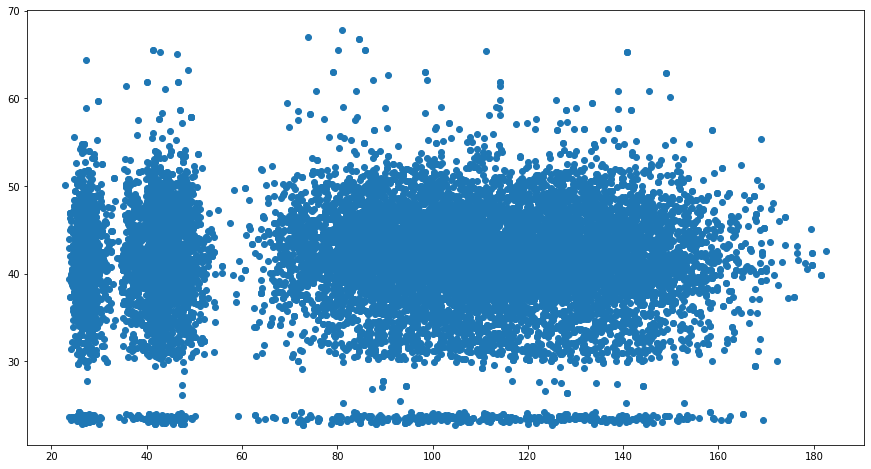

In [32]:
print(dfrender['powerDrawWatt_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['powerDrawWatt_x'],dfrender['timediff'])

0.03970412776614891


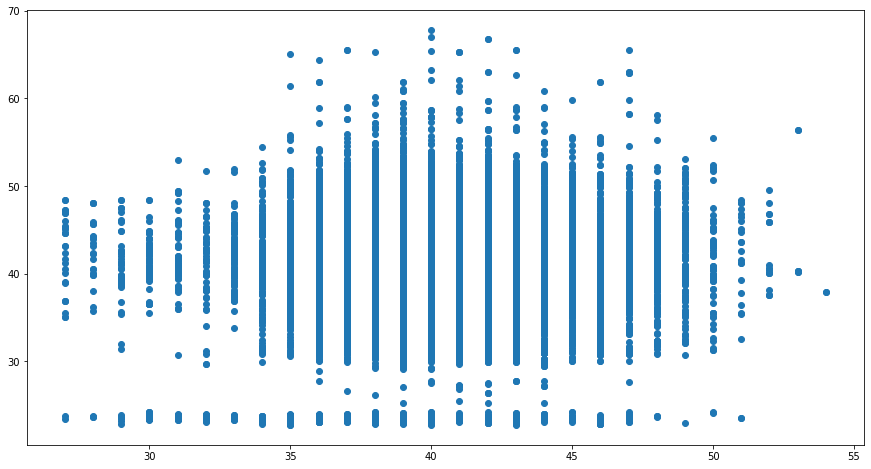

In [33]:
print(dfrender['gpuTempC_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['gpuTempC_x'],dfrender['timediff'])

0.020095762606532414


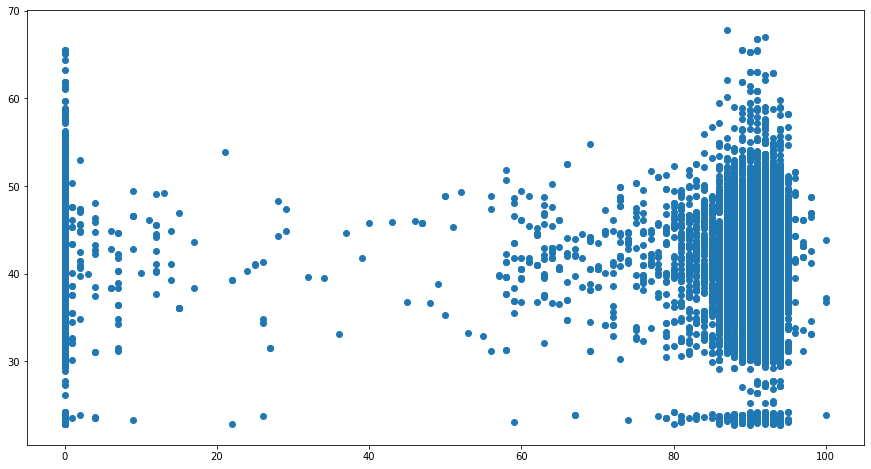

In [34]:
print(dfrender['gpuUtilPerc_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['gpuUtilPerc_x'],dfrender['timediff'])

0.017096723765912362


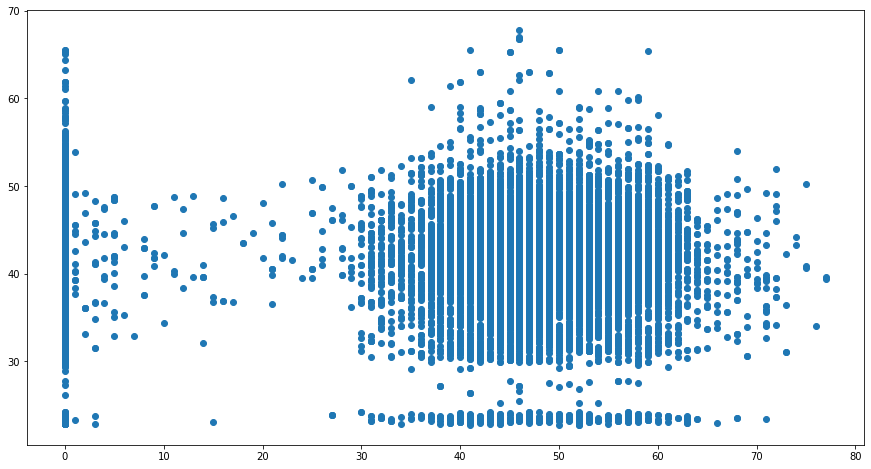

In [35]:
print(dfrender['gpuMemUtilPerc_x'].corr(dfrender['timediff']))
plt.scatter(dfrender['gpuMemUtilPerc_x'],dfrender['timediff'])

In [38]:
dfrender1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x),avg(timediff) from dfrender group by eventName')
dfrender1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x),avg(timediff)
0,91.307876,40.326308,64.990254,34.497505,41.27797


In [39]:
dfsavingconfig=ps.sqldf('select * from df3merge where eventName="Saving Config" ')
dfsavingconfig

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.574000,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,db871cd77a544e13bc791a64a0c8ed50000010,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,8a8e3266-68dd-4ef1-b99a-b3e88ec9a970,2018-11-08 08:27:10.577000,4a79b6d2616049edbf06c6aa58ab426a000011,325217084713,GPU-45073596-b4bd-bb16-2ec4-12d5f8aeef44,42.64,37,0,0,db871cd77a544e13bc791a64a0c8ed50000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.003
1,2018-11-08 08:27:13.460000,265232c5f6814768aeefa66a7bec6ff600000S,323617043068,GPU-976b3bbd-fdea-ee53-615f-a98f28408299,125.99,44,94,53,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
2,2018-11-08 08:27:13.460000,0745914f4de046078517041d70b22fe700000E,325017017790,GPU-769c04e0-4916-d031-0e0c-7d13fdde3e3d,39.31,35,0,0,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
3,2018-11-08 08:27:13.460000,6139a35676de44d6b61ec247f0ed8657000019,320218055685,GPU-c5b20fb1-a8a2-3699-9def-2db4f6b0abc6,110.95,42,89,49,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
4,2018-11-08 08:27:13.460000,95b4ae6d890e4c46986d91d7ac4bf08200000S,325217085955,GPU-019fdcd4-8840-a5d2-9bce-7e19077e0f6c,88.22,40,93,54,4ad946d4435c42dabb5073531ea4f31500000J,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,34978715-109f-4c37-b28b-0aaeb4c54675,2018-11-08 08:27:13.462000,4c72fae95b9147189a0559269a6953ff000004,325017048867,GPU-cea5abe6-dfe8-d315-38f8-b691aad56a06,43.80,37,0,0,4ad946d4435c42dabb5073531ea4f31500000J,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17487,2018-11-08 08:27:59.536000,95b4ae6d890e4c46986d91d7ac4bf082000019,325117172961,GPU-8ca429d5-d440-7df3-a699-c1e30e3fa476,114.35,41,91,54,0745914f4de046078517041d70b22fe7000010,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7c67641a-56ca-4ca7-a51e-789b33f1baed,2018-11-08 08:27:59.539000,5903af3699134795af7eafc605ae5fc7000012,325117172501,GPU-749afcd3-def7-dd5d-f0b6-04d45a81f31a,143.97,36,93,73,0745914f4de046078517041d70b22fe7000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.003
17488,2018-11-08 08:28:01.305000,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,124.66,38,93,57,4c72fae95b9147189a0559269a6953ff00000P,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1bbddbdf-ed50-4ee0-a82f-2ad4e2620aa9,2018-11-08 08:28:01.318000,db871cd77a544e13bc791a64a0c8ed5000000J,323617043151,GPU-964c6e6a-4c2b-d843-f187-46d526151dfe,119.40,45,93,54,4c72fae95b9147189a0559269a6953ff00000P,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f74770

-0.002827758702542964


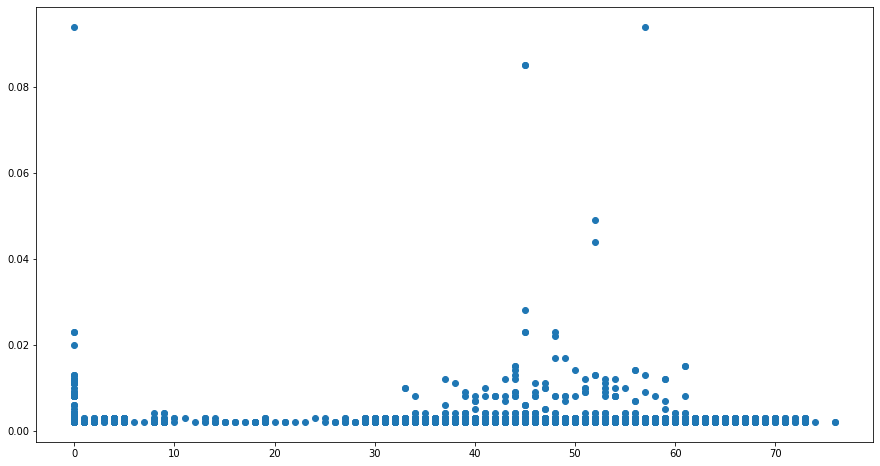

In [40]:
print(dfsavingconfig['gpuMemUtilPerc_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['gpuMemUtilPerc_x'],dfsavingconfig['timediff'])

-0.003939959109769067


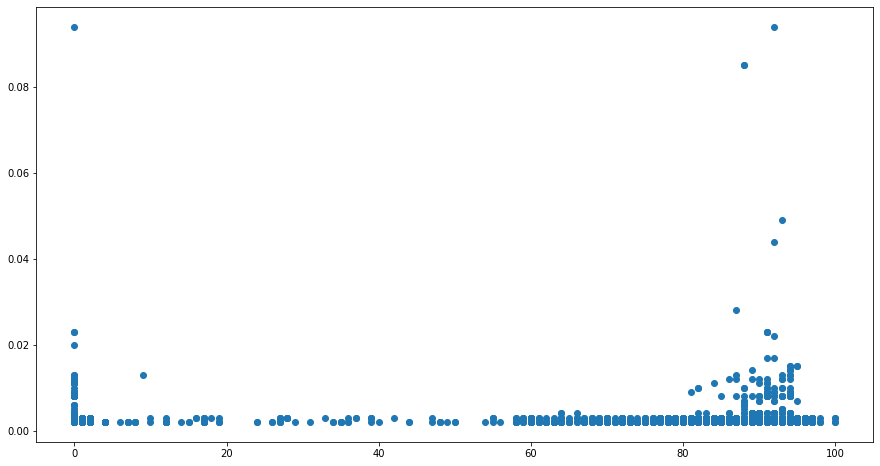

In [41]:
print(dfsavingconfig['gpuUtilPerc_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['gpuUtilPerc_x'],dfsavingconfig['timediff'])

0.01349580814425461


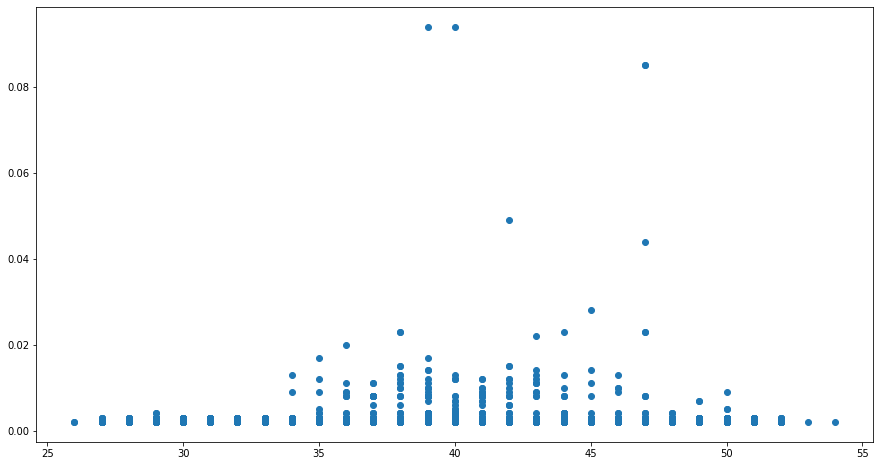

In [42]:
print(dfsavingconfig['gpuTempC_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['gpuTempC_x'],dfsavingconfig['timediff'])

7.148486774412675e-05


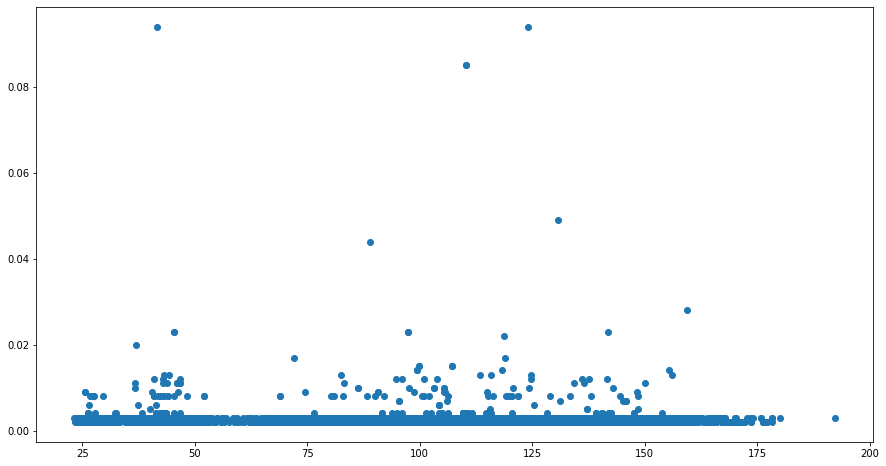

In [43]:
print(dfsavingconfig['powerDrawWatt_x'].corr(dfsavingconfig['timediff']))
plt.scatter(dfsavingconfig['powerDrawWatt_x'],dfsavingconfig['timediff'])

In [ ]:
# dfsavingconfig1=ps.sqldf('select avg(powerDrawWatt),	avg(gpuTempC), avg(gpuUtilPerc),	avg(gpuMemUtilPerc)	 from dfsavingconfig group by eventName')
# dfsavingconfig1

In [45]:
dftiling=ps.sqldf('select * from df3merge where eventName="Tiling" ')
dftiling

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:07.855000,5903af3699134795af7eafc605ae5fc7000014,325017020245,GPU-a7e39f02-521d-647e-a02e-64b49a138e50,49.81,40,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,265232c5f6814768aeefa66a7bec6ff600000O,323617020120,GPU-b7e2dffb-a8da-83e5-686e-ef892e27409d,125.78,42,93,43,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
1,2018-11-08 08:27:07.855000,5903af3699134795af7eafc605ae5fc7000014,325017020245,GPU-a7e39f02-521d-647e-a02e-64b49a138e50,49.81,40,0,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,db871cd77a544e13bc791a64a0c8ed50000001,323617020154,GPU-f82c7dc3-ae8e-9c24-0913-eb90c977e686,41.38,38,2,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
2,2018-11-08 08:27:07.855000,0d56a730076643d585f77e00d2d8521a00000B,325017017512,GPU-971d7d26-9fb1-ab60-5180-75d82081d8cf,122.79,37,91,45,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,265232c5f6814768aeefa66a7bec6ff600000O,323617020120,GPU-b7e2dffb-a8da-83e5-686e-ef892e27409d,125.78,42,93,43,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
3,2018-11-08 08:27:07.855000,0d56a730076643d585f77e00d2d8521a00000B,325017017512,GPU-971d7d26-9fb1-ab60-5180-75d82081d8cf,122.79,37,91,45,b9a1fa7ae2f74eb68f25f607980f97d700000Z,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,55423784-28a8-44ab-972a-46d87b280206,2018-11-08 08:27:08.901000,db871cd77a544e13bc791a64a0c8ed50000001,323617020154,GPU-f82c7dc3-ae8e-9c24-0913-eb90c977e686,41.38,38,2,0,b9a1fa7ae2f74eb68f25f607980f97d700000Z,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.046
4,2018-11-08 08:27:13.845000,83ea61ac1ef54f27a3bf7bd0f41ecaa7000018,323617021519,GPU-0d5cec28-4daf-bab0-b4e8-2e53a81b48b1,97.67,43,92,46,b9a1fa7ae2f74eb68f25f607980f97d7000009,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,e76ac902-ed0e-40b4-987c-8c71a876edac,2018-11-08 08:27:14.970000,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,26.12,37,0,0,b9a1fa7ae2f74eb68f25f607980f97d7000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17169,2018-11-08 08:27:49.802000,4ad946d4435c42dabb5073531ea4f315000016,320118119761,GPU-c03f9fc5-e123-f7d0-ba63-e406952669d0,48.17,37,0,0,95b4ae6d890e4c46986d91d7ac4bf082000009,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,ee8725d6-786f-4d5a-82fe-c283e61748a7,2018-11-08 08:27:50.781000,d8241877cd994572b46c861e5d144c8500001C,323617020369,GPU-ea11c851-c572-00cb-35dc-43076715b198,104.84,43,88,35,95b4ae6d890e4c46986d91d7ac4bf082000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.979
17170,2018-11-08 08:27:57.831000,a77ef58b13ad4c01b769dac8409af3f800000N,323217056029,GPU-50c55268-e212-7e5f-a682-00b66c46dc14,72.30,41,90,42,d8241877cd994572b46c861e5d144c8500000F,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,5ff7cf8c-dab4-4a83-b826-a9de1b7f0ed2,2018-11-08 08:27:58.764000,e7adc42d28814e518e9601ac2329c513000004,325217085332,GPU-d856c0d9-2c0c-32a4-1e08-600cdea6fca5,85.75,40,85,39,d8241877cd994572b46c861e5d144c8500000F,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.933
17171,2018-11-08 08:28:02.852000,d8241877cd

0.007008263809843065


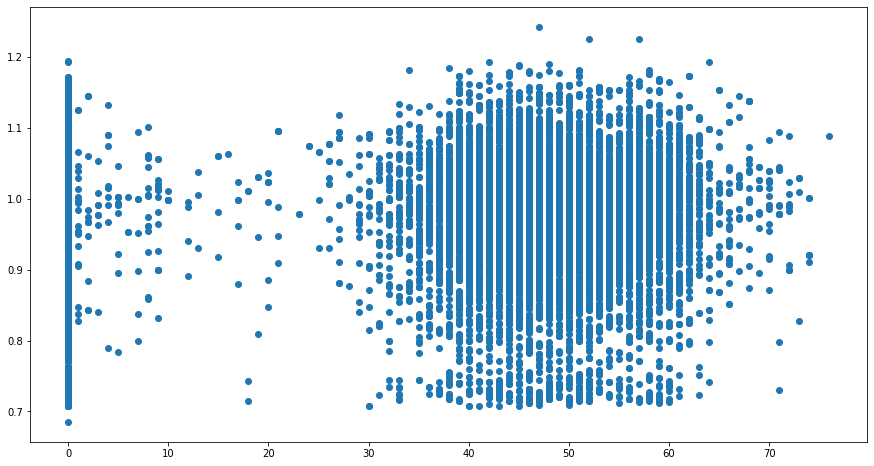

In [46]:
print(dftiling['gpuMemUtilPerc_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['gpuMemUtilPerc_x'],dftiling['timediff'])

0.0030209215482463864


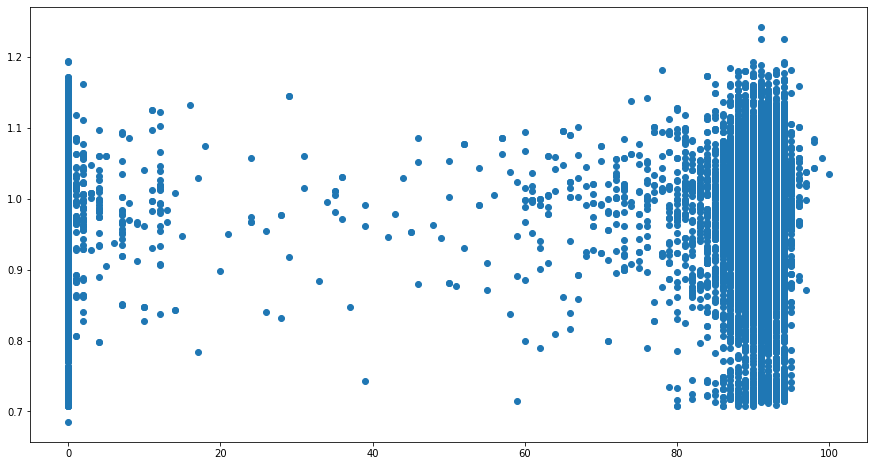

In [47]:
print(dftiling['gpuUtilPerc_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['gpuUtilPerc_x'],dftiling['timediff'])

0.028906763438730738


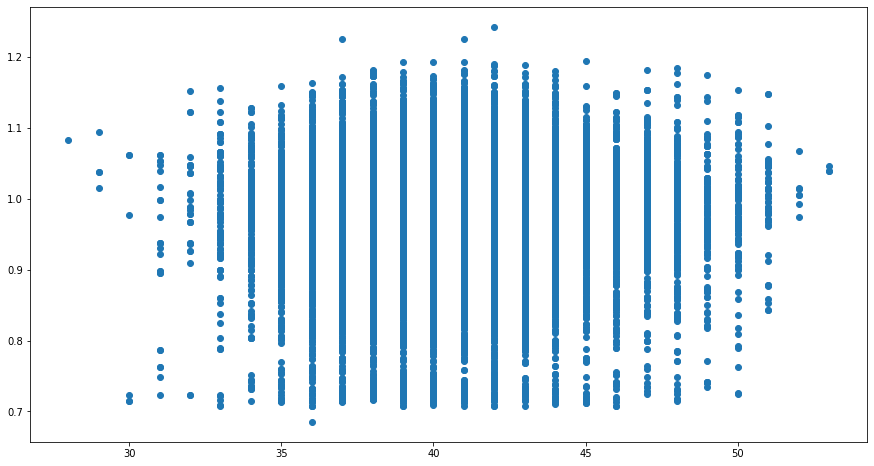

In [48]:
print(dftiling['gpuTempC_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['gpuTempC_x'],dftiling['timediff'])

0.004981138467593851


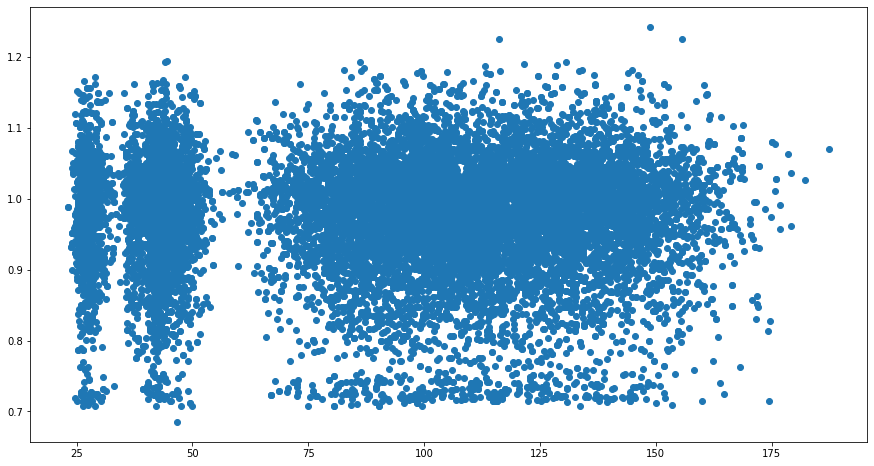

In [49]:
print(dftiling['powerDrawWatt_x'].corr(dftiling['timediff']))
plt.scatter(dftiling['powerDrawWatt_x'],dftiling['timediff'])

In [50]:
dftiling1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from dftiling group by eventName')
dftiling1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,92.071739,40.531967,65.994177,34.988995


In [51]:
dfuploading=ps.sqldf('select * from df3merge where eventName="Uploading" ')
dfuploading

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.875000,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000,95b4ae6d890e4c46986d91d7ac4bf08200000T,324917052614,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121
1,2018-11-08 08:27:10.359000,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000,04dc4e9647154250beeee51b866b071500001C,323617020155,GPU-51b7ec74-a5ac-06b7-1fd0-9c11ce579ffc,28.05,39,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
2,2018-11-08 08:27:10.359000,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000,b9a1fa7ae2f74eb68f25f607980f97d7000012,325117172395,GPU-50f23433-71f3-6f16-3c86-0de884dc7493,44.21,37,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
3,2018-11-08 08:27:15.057000,dcc19f48bb3445a28338db3a8f002e9c00000Y,323617020762,GPU-48504260-2b36-e796-830a-8dc7b9ab851a,102.97,42,89,42,a77ef58b13ad4c01b769dac8409af3f8000015,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,98ba792b-ab4f-44f1-a3fe-6dd2e770723e,2018-11-08 08:27:15.977000,cd44f5819eba427a816e7ce648adceb200001B,323217049007,GPU-72429cfd-57a1-129b-9615-9045cc682ee9,151.70,45,91,46,a77ef58b13ad4c01b769dac8409af3f8000015,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.920
4,2018-11-08 08:27:15.883000,4c72fae95b9147189a0559269a6953ff00000V,325017049278,GPU-0c038861-d224-604e-f31b-e6b0fef9b6f3,106.59,42,90,44,4c72fae95b9147189a0559269a6953ff000007,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,d968d511-49bf-4c0b-a2ab-c40f15b89c06,2018-11-08 08:27:16.822000,e7adc42d28814e518e9601ac2329c513000017,325117062966,GPU-3c1412e7-4c3c-aa4c-329a-776ba672aece,147.12,39,91,50,4c72fae95b9147189a0559269a6953ff000007,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0.939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17453,2018-11-08 08:28:00.053000,8b6a0eebc87b4cb2b0539e81075191b9000013,323217056452,GPU-be873659-353f-954b-9866-a24c951bab0c,112.34,46,89,40,95b4ae6d890e4c46986d91d7ac4bf08200000A,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b3a1edf4-5139-4a7f-9fe1-48cbe08cee4f,2018-11-08 08:28:01.214000,4c72fae95b9147189a0559269a6953ff000008,320118118866,GPU-cb946eab-ad72-d047-a11e-cc58ab19abe5,116.22,41,88,38,95b4ae6d890e4c46986d91d7ac4bf08200000A,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.161
17454,2018-11-08 08:27:58.987000,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,101.52,40,89,42,265232c5f6814768aeefa66a7bec6ff600000L,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,fd0c3c22-4f0f-4a0d-8c31-d26a87fdc5f9,2018-11-08 08:28:00.252000,4c72fae95b9147189a0559269a6953ff00000V,325017049278,GPU-0c038861-d224-604e-f31b-e6b0fef9b6f3,61.78,40,90,60,265232c5f6814768aeefa66a7bec6ff600000L,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.265
17455,2018-1

-0.05001497044371302


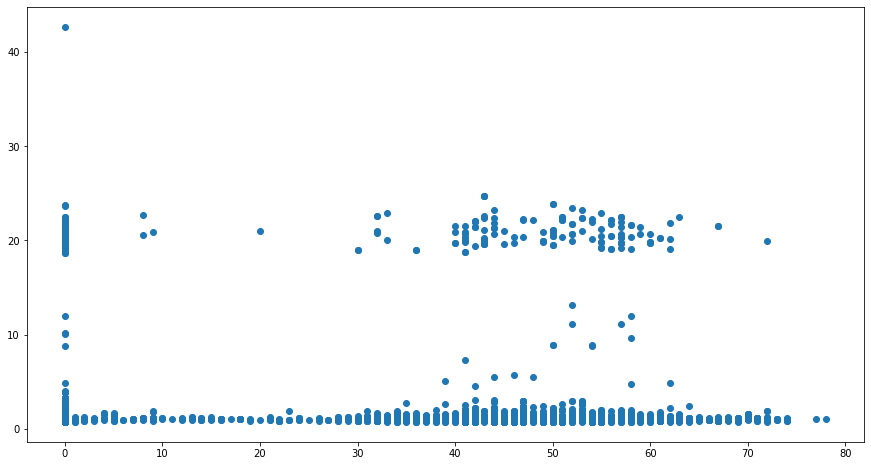

In [52]:
print(dfuploading['gpuMemUtilPerc_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['gpuMemUtilPerc_x'],dfuploading['timediff'])

-0.054184835287796655


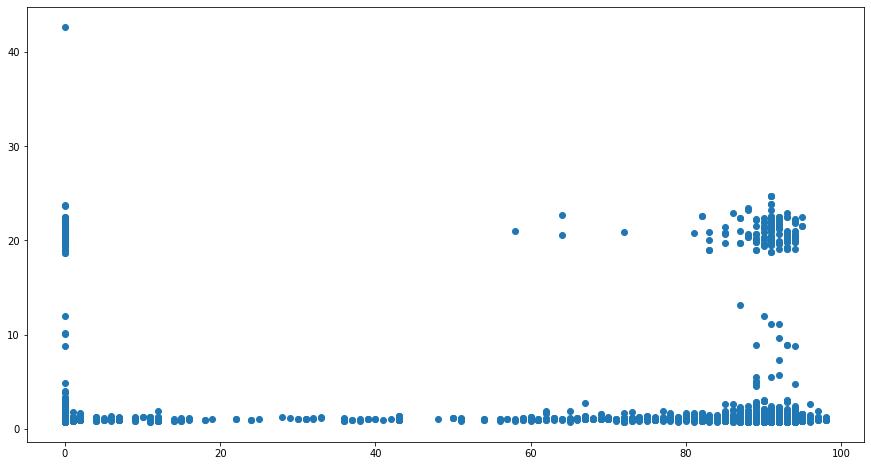

In [53]:
print(dfuploading['gpuUtilPerc_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['gpuUtilPerc_x'],dfuploading['timediff'])

-0.1350483028249642


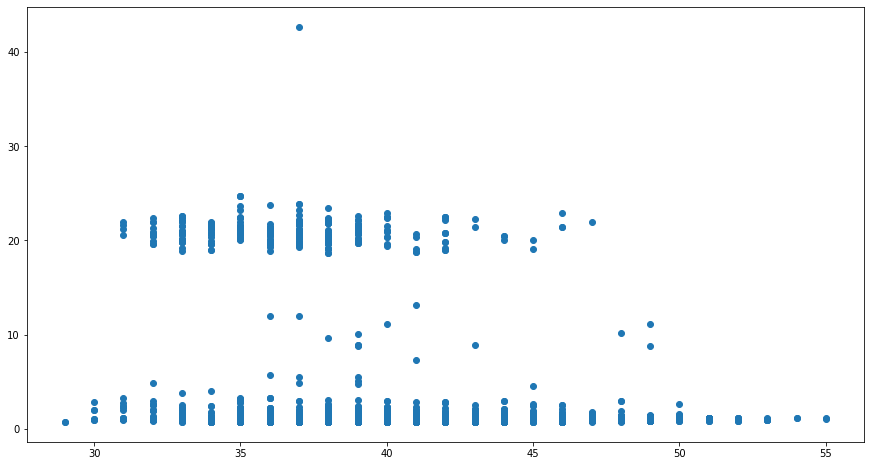

In [54]:
print(dfuploading['gpuTempC_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['gpuTempC_x'],dfuploading['timediff'])

-0.06511976999920151


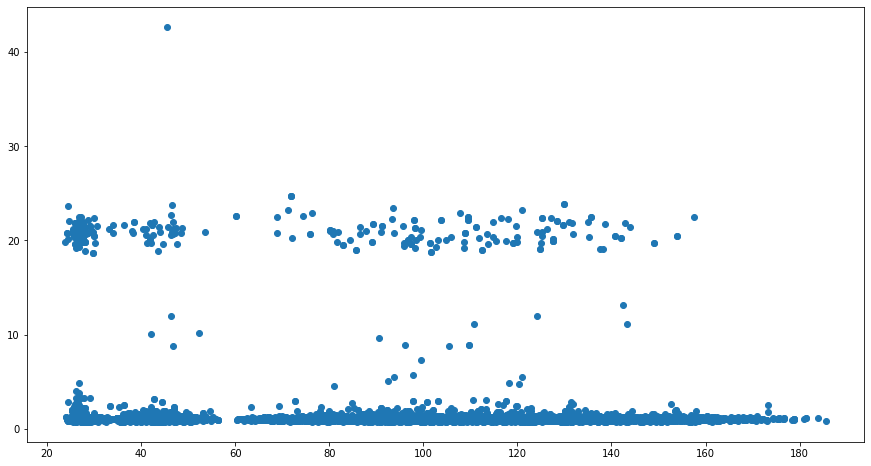

In [55]:
print(dfuploading['powerDrawWatt_x'].corr(dfuploading['timediff']))
plt.scatter(dfuploading['powerDrawWatt_x'],dfuploading['timediff'])

In [56]:
dfuploading1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from dfuploading group by eventName')
dfuploading1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,91.572035,40.449708,65.517413,34.740807


In [70]:
dfgpu= ps.sqldf('select gpuSerial_x ,avg(timediff) as average_time, avg(gpuUtilPerc_x) as average_utilization from df3merge group by gpuSerial_x')
dfgpu['average_performance']=dfgpu['average_utilization']-dfgpu['average_time']
dfgpu=ps.sqldf('select * from dfgpu order by average_performance')
dfgpu

,gpuSerial_x,average_time,average_utilization,average_performance
0,323217056324,21.758720,43.853659,22.094939
1,325117171574,16.788603,43.544118,26.755515
2,323217056398,18.294955,46.045455,27.750500
3,323617020128,24.706010,52.704762,27.998752
4,325017019732,20.329644,48.724138,28.394494
...,...,...,...,...
1019,325117172235,13.323979,79.458333,66.134354
1020,324917147026,14.397060,80.559524,66.162464
1021,325117171578,14.922148,81.318182,66.396034
1022,325117063226,13.415736,80.622642,67.206906


In [ ]:
# df3= pd.merge(df1,df2)
# df4=pd.merge(df,df2)
# df5=pd.merge(df3,df4)

In [ ]:
# df3.to_csv('mergetaskapplication.csv')
# df4.to_csv('mergegpuapplication.csv')
# df5.to_csv('mergeall.csv')